In [105]:
#Useful imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, asin, acos, atan
%reload_ext autoreload
%autoreload 2
plt.style.use('latex.mplstyle')

In [106]:
def reject_outliers(data, m=3.5):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = 0.6745*d/mdev if mdev else 0.0
    return data[s<m]

def average_without_outliers(val):
    valid_measurements = reject_outliers(val)
    ratio = 100*len(valid_measurements)/len(val)
    print('success rate: {:2.0f}% ({}/{})'.format(ratio,len(valid_measurements),len(val)))
    return np.mean(valid_measurements), ratio

def robust_average(errs_dict, print_out=False):
    # Remove outliers
    from plots_cti import plot_matrix
    avg_errs_dict = errs_dict.copy()
    success_dict = errs_dict.copy()
    for key, val in errs_dict.items():
        # fill up list if not all ones are the same length.
        max_length = np.max([len(arr) for arr in val])
        for v in val:
            left = max_length - len(v)
            # add fill-values that will not be considered in the average.
            [v.append(100000000) for l in range(left)]
        val_arr = np.array(val)
        if print_out:
            plot_matrix(val_arr, title=key)
        avg_errs_dict[key] = []
        success_dict[key] = []
        for values in val_arr:
            valid_measurements = reject_outliers(values)
            avg_errs_dict[key].append(np.mean(valid_measurements))
            success_dict[key].append(100*len(valid_measurements)/len(values))
    success_dict['noise'] = avg_errs_dict['noise']
    return avg_errs_dict, success_dict

def plot_errors(errs_dict, title, new_keys, ignore, saveas='', 
                min_idx = 0, max_idx=20, xscale='linear',yscale='linear', fit=False):
    ymax = 0
    i = 0
    plt.figure()
    ax = plt.gca()
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    x = errs_dict['noise']

    x = x[min_idx:max_idx]
    for key, val in errs_dict.items():
        val = val[min_idx:max_idx]
        new_key = new_keys[i]
        if new_key not in ignore:
            plt.scatter(x, val,label=new_key)
            if xscale == 'log' and yscale =='log' and fit:  
                logx=np.log(x)
                logy=np.log(val)
                coeffs = np.polyfit(logx,logy,deg=2)
                poly = np.poly1d(coeffs)
                yfit = lambda x: np.exp(poly(np.log(x)))
                plt.loglog(x,yfit(x),':')
            if xscale == 'linear' and yscale == 'linear' and fit:
                plt.plot(np.unique(x), np.poly1d(np.polyfit(x, val, 1))(np.unique(x)))
            ymax = max(ymax, max(val))
        i = i + 1
    if yscale == 'linear':
        yticks = ax.get_yticks()
        ax.set_yticklabels(['{:2.0e}'.format(ys) for ys in yticks])
    #plt.legend(loc='upper left')
    plt.legend(loc='best')
    plt.title(title)
    plt.ylim([0,ymax])
    plt.xlim([min(x),max(x)])
    plt.ylabel('MSE of localization')
    plt.xlabel('RMSE of distances')
    plt.tight_layout()
    if saveas != '':
        plt.savefig(saveas)
    plt.show()

def plot_success(success_dict, title, new_keys, ignore, saveas='', 
                 min_idx = 0, max_idx=20, xscale='log',fit=False):
    i = 0
    plt.figure()
    ax = plt.gca()
    ax.set_xscale(xscale)
    x = success_dict['noise']
    x = x[min_idx:max_idx]
    for key, val in success_dict.items():
        val = val[min_idx:max_idx]
        new_key = new_keys[i]
        if new_key not in ignore:
            plt.plot(x, val,label=new_key)
            if xscale == 'log' and fit:  
                logx=np.log(x)
                logy=val
                coeffs = np.polyfit(logx,logy,deg=2)
                poly = np.poly1d(coeffs)
                yfit = lambda x: poly(np.log(x))
                plt.semilogx(x,yfit(x),':')
            if xscale == 'linear' and fit:
                plt.plot(np.unique(x), np.poly1d(np.polyfit(x, val, 1))(np.unique(x)))
        i = i + 1
    plt.legend(loc='best')
    plt.title(title)
    plt.ylim([50,105])
    plt.xlim([min(x),max(x)])
    plt.ylabel('Success rate')
    plt.xlabel('RMSE of distances')
    plt.tight_layout()
    if saveas != '':
        plt.savefig(saveas)
    plt.show()

In [107]:
name='A_complete'
errs_dict = np.load('results/{}_errs_dict.npy'.format(name)).item()
avg_errs_dict, success_dict = robust_average(errs_dict, print_out=False)

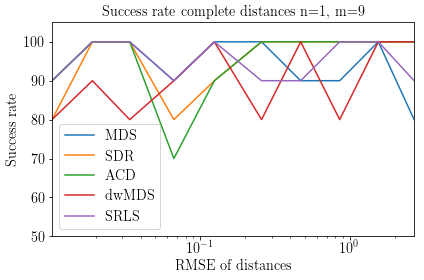

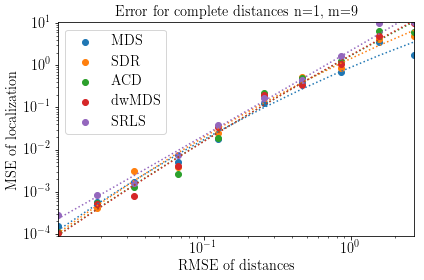

In [108]:
new_keys = ['noise','MDS','MDS alternating','MDS OptSpace','SDR','ACD','dwMDS','SRLS']
ignore = ['noise','MDS alternating','MDS OptSpace']
min_idx = 0
max_idx = 20
xscale = 'log'
yscale = 'log'

title = 'Success rate complete distances n=1, m=9'
saveas = 'results/suc_{}.png'.format(name)
plot_success(success_dict, title, new_keys, ignore, saveas=saveas, 
                 min_idx = 0, max_idx=20, xscale='log',fit=False)
title = 'Error for complete distances n=1, m=9'
saveas = 'results/err_{}.png'.format(name)
plot_errors(avg_errs_dict, 
            new_keys=new_keys, 
            ignore=ignore, 
            title=title, saveas=saveas, 
            min_idx=min_idx, max_idx=max_idx, 
            xscale=xscale, yscale=yscale, 
            fit=True)

dict_keys(['noise', 'MDS', 'MDSalternate', 'MDSoptspace', 'SDR', 'ACD', 'dwMDS', 'SRLS'])


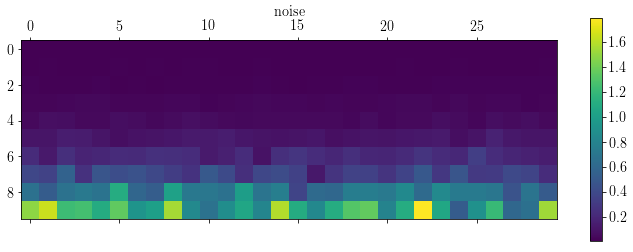

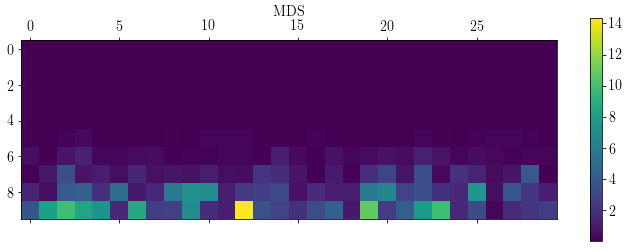

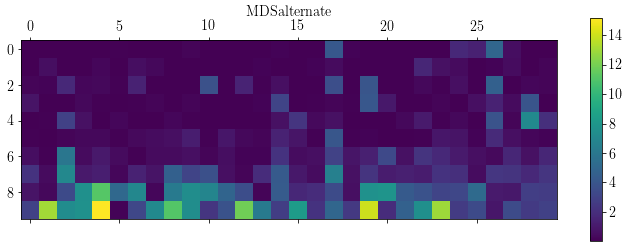

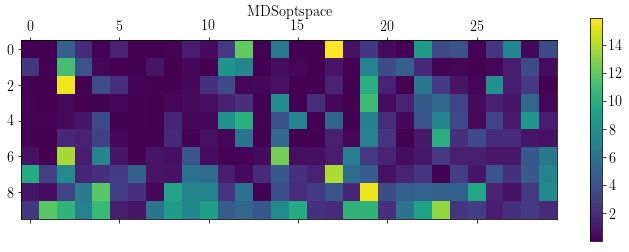

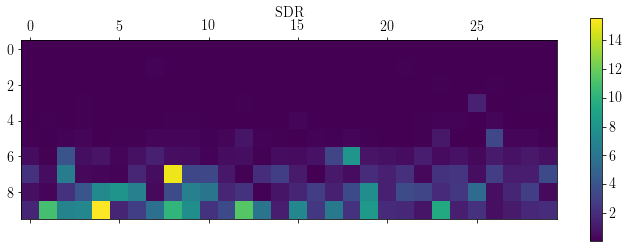

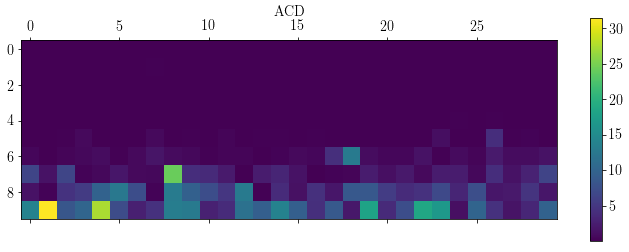

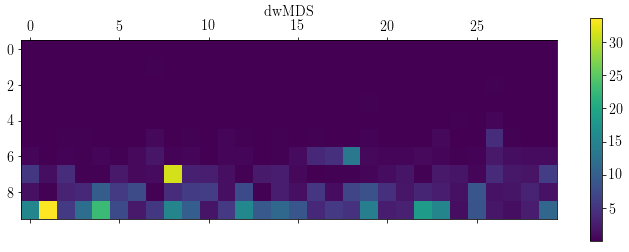

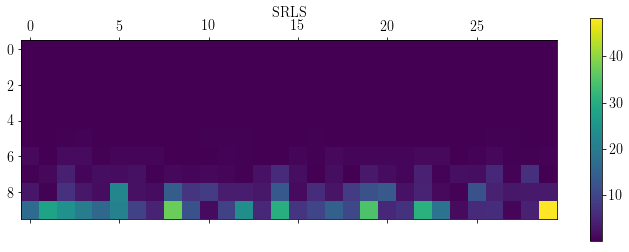

dict_keys(['noise', 'MDS', 'MDSalternate', 'MDSoptspace', 'SDR', 'ACD', 'dwMDS', 'SRLS'])


In [121]:
name='A_missing'
errs_dict = np.load('results/{}_errs_dict.npy'.format(name)).item()
print(errs_dict.keys())
avg_errs_dict, success_dict = robust_average(errs_dict, print_out=True)
print(avg_errs_dict.keys())

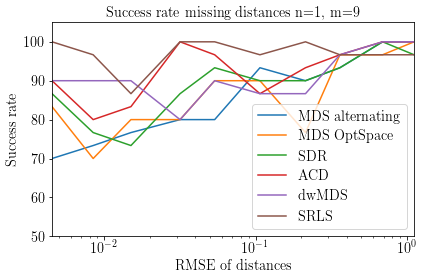

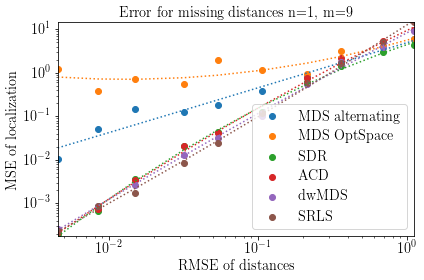

In [122]:
new_keys = ['noise','MDS','MDS alternating','MDS OptSpace','SDR','ACD','dwMDS','SRLS']
ignore = ['noise','MDS']
min_idx = 0
max_idx = 20
xscale = 'log'
yscale = 'log'

title = 'Success rate missing distances n=1, m=9'
saveas = 'results/suc_{}.png'.format(name)
plot_success(success_dict, title, new_keys, ignore, saveas=saveas, 
                 min_idx = 0, max_idx=20, xscale='log',fit=False)
title = 'Error for missing distances n=1, m=9'
saveas = 'results/err_{}.png'.format(name)
plot_errors(avg_errs_dict, 
            new_keys=new_keys, 
            ignore=ignore, 
            title=title, saveas=saveas, 
            min_idx=min_idx, max_idx=max_idx, 
            xscale=xscale, yscale=yscale, 
            fit=True)